In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.05, 1.05]

## The model

In [3]:
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.3]
model.copula_parameters = theta
model.shapley_indices = [1./dim]*dim
if dim == 2 and beta is None:
    output_var = dim*( 1 + sum(theta))
    model.first_order_sobol_indices = [(1 + 2*theta[0] + theta[0]**2)/output_var]*dim
    model.total_sobol_indices = [(1.- theta[0]**2)/output_var]*dim

In [4]:
if None:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.9]
    model.copula_parameters = theta

## Sobol indices with a classical Monte-Carlo sampling

In [5]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_perms = None
Nv = 500
No = 50
Ni = 25

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

In [6]:
n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

In [7]:
shapley_results.true_first_indices = model.first_order_sobol_indices
shapley_results.true_total_indices = model.total_sobol_indices
shapley_results.true_shapley_indices = model.shapley_indices

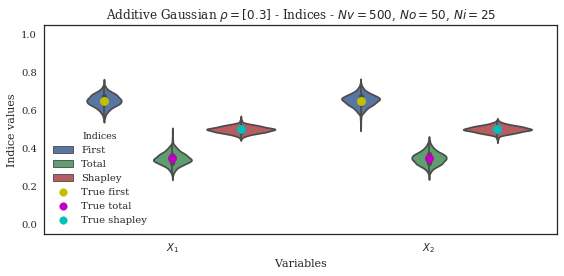

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_additive_gaussian.pdf')

In [9]:
def get_confidence_interval(results, quantiles=[2.5, 97.5]):
    """
    """
    interval = 2*results[:, 0].T - np.percentile(results, quantiles[::-1], axis=1)
    return interval.T

In [10]:
get_confidence_interval(shapley_results.full_shapley_indices)

array([[ 0.46922843,  0.53461753],
       [ 0.46538247,  0.53077157]])

In [11]:
get_confidence_interval(shapley_results.full_first_indices)

array([[ 0.56667483,  0.69495867],
       [ 0.56277133,  0.69107957]])

In [12]:
get_confidence_interval(shapley_results.full_total_indices)

array([[ 0.30892043,  0.43722867],
       [ 0.30504133,  0.43332517]])

## Kriging Model

In [16]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 10
basis = 'quadratic'
kernel = 'matern'
library = 'OT'
sampling = 'monte-carlo'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [17]:
Nv = 500
No = 50
Ni = 25
n_realization = 50
n_perms = np.math.factorial(dim)
Nv + n_perms * (dim-1) * No * Ni

3000

In [18]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
Nv = 500
No = 50
Ni = 25
n_realization = 50

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

KeyboardInterrupt: 

In [ ]:
n_boot = 100
shapley_kriging_results = shapley_kriging.compute_indices(n_boot=n_boot)

In [ ]:
shapley_kriging_results.true_first_indices = model.first_order_sobol_indices
shapley_kriging_results.true_total_indices = model.total_sobol_indices
shapley_kriging_results.true_shapley_indices = model.shapley_indices

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')